In [86]:
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.style
import matplotlib as mpl

mpl.style.use('seaborn-v0_8-darkgrid')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

users = pd.read_csv('../preproc_users_view.csv')
tweets_view = pd.read_csv('../preproc_tweets_view.csv')

users_view = users[users.user_id.isin(tweets_view.user_id.unique())].copy()
tweets_view['all_hashtags'] = tweets_view['all_hashtags'].map(eval)
tweets_view['original_hashtags'] = tweets_view['original_hashtags'].map(eval)
tweets_view['quote_hashtags'] = tweets_view['quote_hashtags'].map(eval)
tweets_view['user_mentions'] = tweets_view['user_mentions'].map(eval)

stats_df = pd.DataFrame(
    [
        '{:,}'.format(len(users[users.is_croatian == True])),
        '{:,}'.format(len(tweets_view.user_id.unique())),
        '{:,}'.format(len(tweets_view)),
        
        '{0:.2f}%'.format(tweets_view['out_original_tweets_pct'].mean()*100),
        '{0:.2f}%'.format(tweets_view['out_retweet_tweets_pct'].mean()*100),
        '{:,}'.format(tweets_view['is_reply'].sum()),
        '{:,}'.format(tweets_view['is_quote'].sum()),
        
        tweets_view.created_at.min(),
        tweets_view.created_at.max()

    ],
    index=[
        "Croatian Users (global) #",
        "Croatian Users (tweets) #",
        "Tweets #",
        
        "Original %",
        "Reweets %",
        "Replies #",
        "Quotes #",
        
        "Earliest Tweet date",
        "Latest Tweet date"
    ],
    columns=['Tweets Data']
)

users_view = users_view[users_view.user_id.isin(tweets_view.user_id.unique())]

stats_df

Tweets Data
Croatian Users (global) #                     32,328
Croatian Users (tweets) #                      6,756
Tweets #                                     412,345
Original %                                    68.94%
Reweets %                                     31.06%
Replies #                                    174,799
Quotes #                                      18,008
Earliest Tweet date        2022-11-01 00:00:12+00:00
Latest Tweet date          2022-12-04 00:59:41+00:00

In [87]:
tweets_view.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412345 entries, 0 to 412344
Data columns (total 59 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   out_quote_tweets_cnt      412345 non-null  int64  
 1   retweet_from_screen_name  128083 non-null  object 
 2   out_favorite_cnt          412345 non-null  int64  
 3   out_retweet_tweets_pct    412345 non-null  float64
 4   out_quote_tweets_pct      412345 non-null  float64
 5   is_reply                  412345 non-null  bool   
 6   day_name                  412345 non-null  object 
 7   is_original               412345 non-null  bool   
 8   folder_name               412345 non-null  object 
 9   friends_count             412345 non-null  int64  
 10  in_quote_timedelta_sec    262012 non-null  float64
 11  in_retweet_timedelta_sec  345781 non-null  float64
 12  is_quote                  412345 non-null  bool   
 13  in_quote_tweets_cnt       412345 non-null  f

In [88]:
hashtags_view = tweets_view[tweets_view['is_retweet'] == True].groupby(['year', 'month', 'week', 'day', 'screen_name', 'retweet_from_screen_name']).agg(
    retweet_favorite_cnt=('retweet_favorite_count', 'sum'),
    retweet_timedelta_sec=('in_retweet_timedelta_sec', 'mean'),
    original_hashtags=('original_hashtags', 'sum')
)
hashtags_view

retweet_favorite_cnt  \
year month week day screen_name   retweet_from_screen_name                         
2022 11    44   1   0x1337_       DavidHasselhoff                         1659.0   
                    0xJunge       Crypto_Matters_                            4.0   
                    0xLiquidFire  designershumor                           312.0   
                    1970_zg       Ilia32232588                              60.0   
                                  Ivanbig7                                 272.0   
...                                                                          ...   
     12    48   4   plivamuzlajno insertrndm_name                           46.0   
                    skoobiman     SanJoseSharks                            117.0   
                                  chargers                                 245.0   
                                  nocontextcfb                            1945.0   
                    yohardwell    KarlreMarks                            74795.0   

                                                            retweet_timedelta_sec  \
year month week day screen_name   retweet_from_screen_name                          
2022 11    44   1   0x1337_       DavidHasselhoff                    7.842527e+04   
                    0xJunge       Crypto_Matters_                    1.314920e+04   
                    0xLiquidFire  designershumor                     2.534340e+04   
                    1970_zg       Ilia32232588                       8.623657e+06   
                                  Ivanbig7                           8.623657e+06   
...                                                                           ...   
     12    48   4   plivamuzlajno insertrndm_name                    1.691142e+05   
                    skoobiman     SanJoseSharks                      1.342721e+05   
                                  chargers                           1.342721e+05   
                                  nocontextcfb                       1.342721e+05   
                    yohardwell    KarlreMarks                        3.421958e+04   

                                                           original_hashtags  
year month week day screen_name   retweet_from_screen_name                    
2022 11    44   1   0x1337_       DavidHasselhoff                  [croatia]  
                    0xJunge       Crypto_Matters_                         []  
                    0xLiquidFire  designershumor                          []  
                    1970_zg       Ilia32232588                            []  
                                  Ivanbig7                                []  
...                                                                      ...  
     12    48   4   plivamuzlajno insertrndm_name                         []  
                    skoobiman     SanJoseSharks                           []  
                                  chargers                                []  
                                  nocontextcfb                            []  
                    yohardwell    KarlreMarks                             []  

[100892 rows x 3 columns]

In [89]:
edgelist = hashtags_view.loc[2022,11].reset_index().explode('original_hashtags')\
  .dropna(subset='original_hashtags') \
  .rename(columns={
    'original_hashtags': 'hashtag',
    'screen_name': 'target',
    'retweet_from_screen_name': 'source'
  }).reset_index().groupby(['source', 'target', 'hashtag']).agg(
    weight=('index', 'size')
  ).reset_index()
edgelist

source          target        hashtag  weight
0                 007   Herochange133  60yearsofBond       1
1              00Hpro      MatijaKuzz        HBARNFT       1
2         00moonjuice       LeeKate25  GenshinImpact       1
3         00moonjuice       LeeKate25  Genshinlmpact       1
4         00moonjuice       LeeKate25        dottore       1
...               ...             ...            ...     ...
27711          zmarqa    anotherlost1        hualian       1
27712          zmarqa    anotherlost1           tgcf       1
27713         zoikips        ImmmDays     albaniagay       1
27714         zumi_UT  KieranEatsShit      deltarune       1
27715  zvonimir_mrsic        dpasaric          COP27       1

[27716 rows x 4 columns]

In [90]:
edgelist.to_csv('edgelist_retweets.csv', index=False)

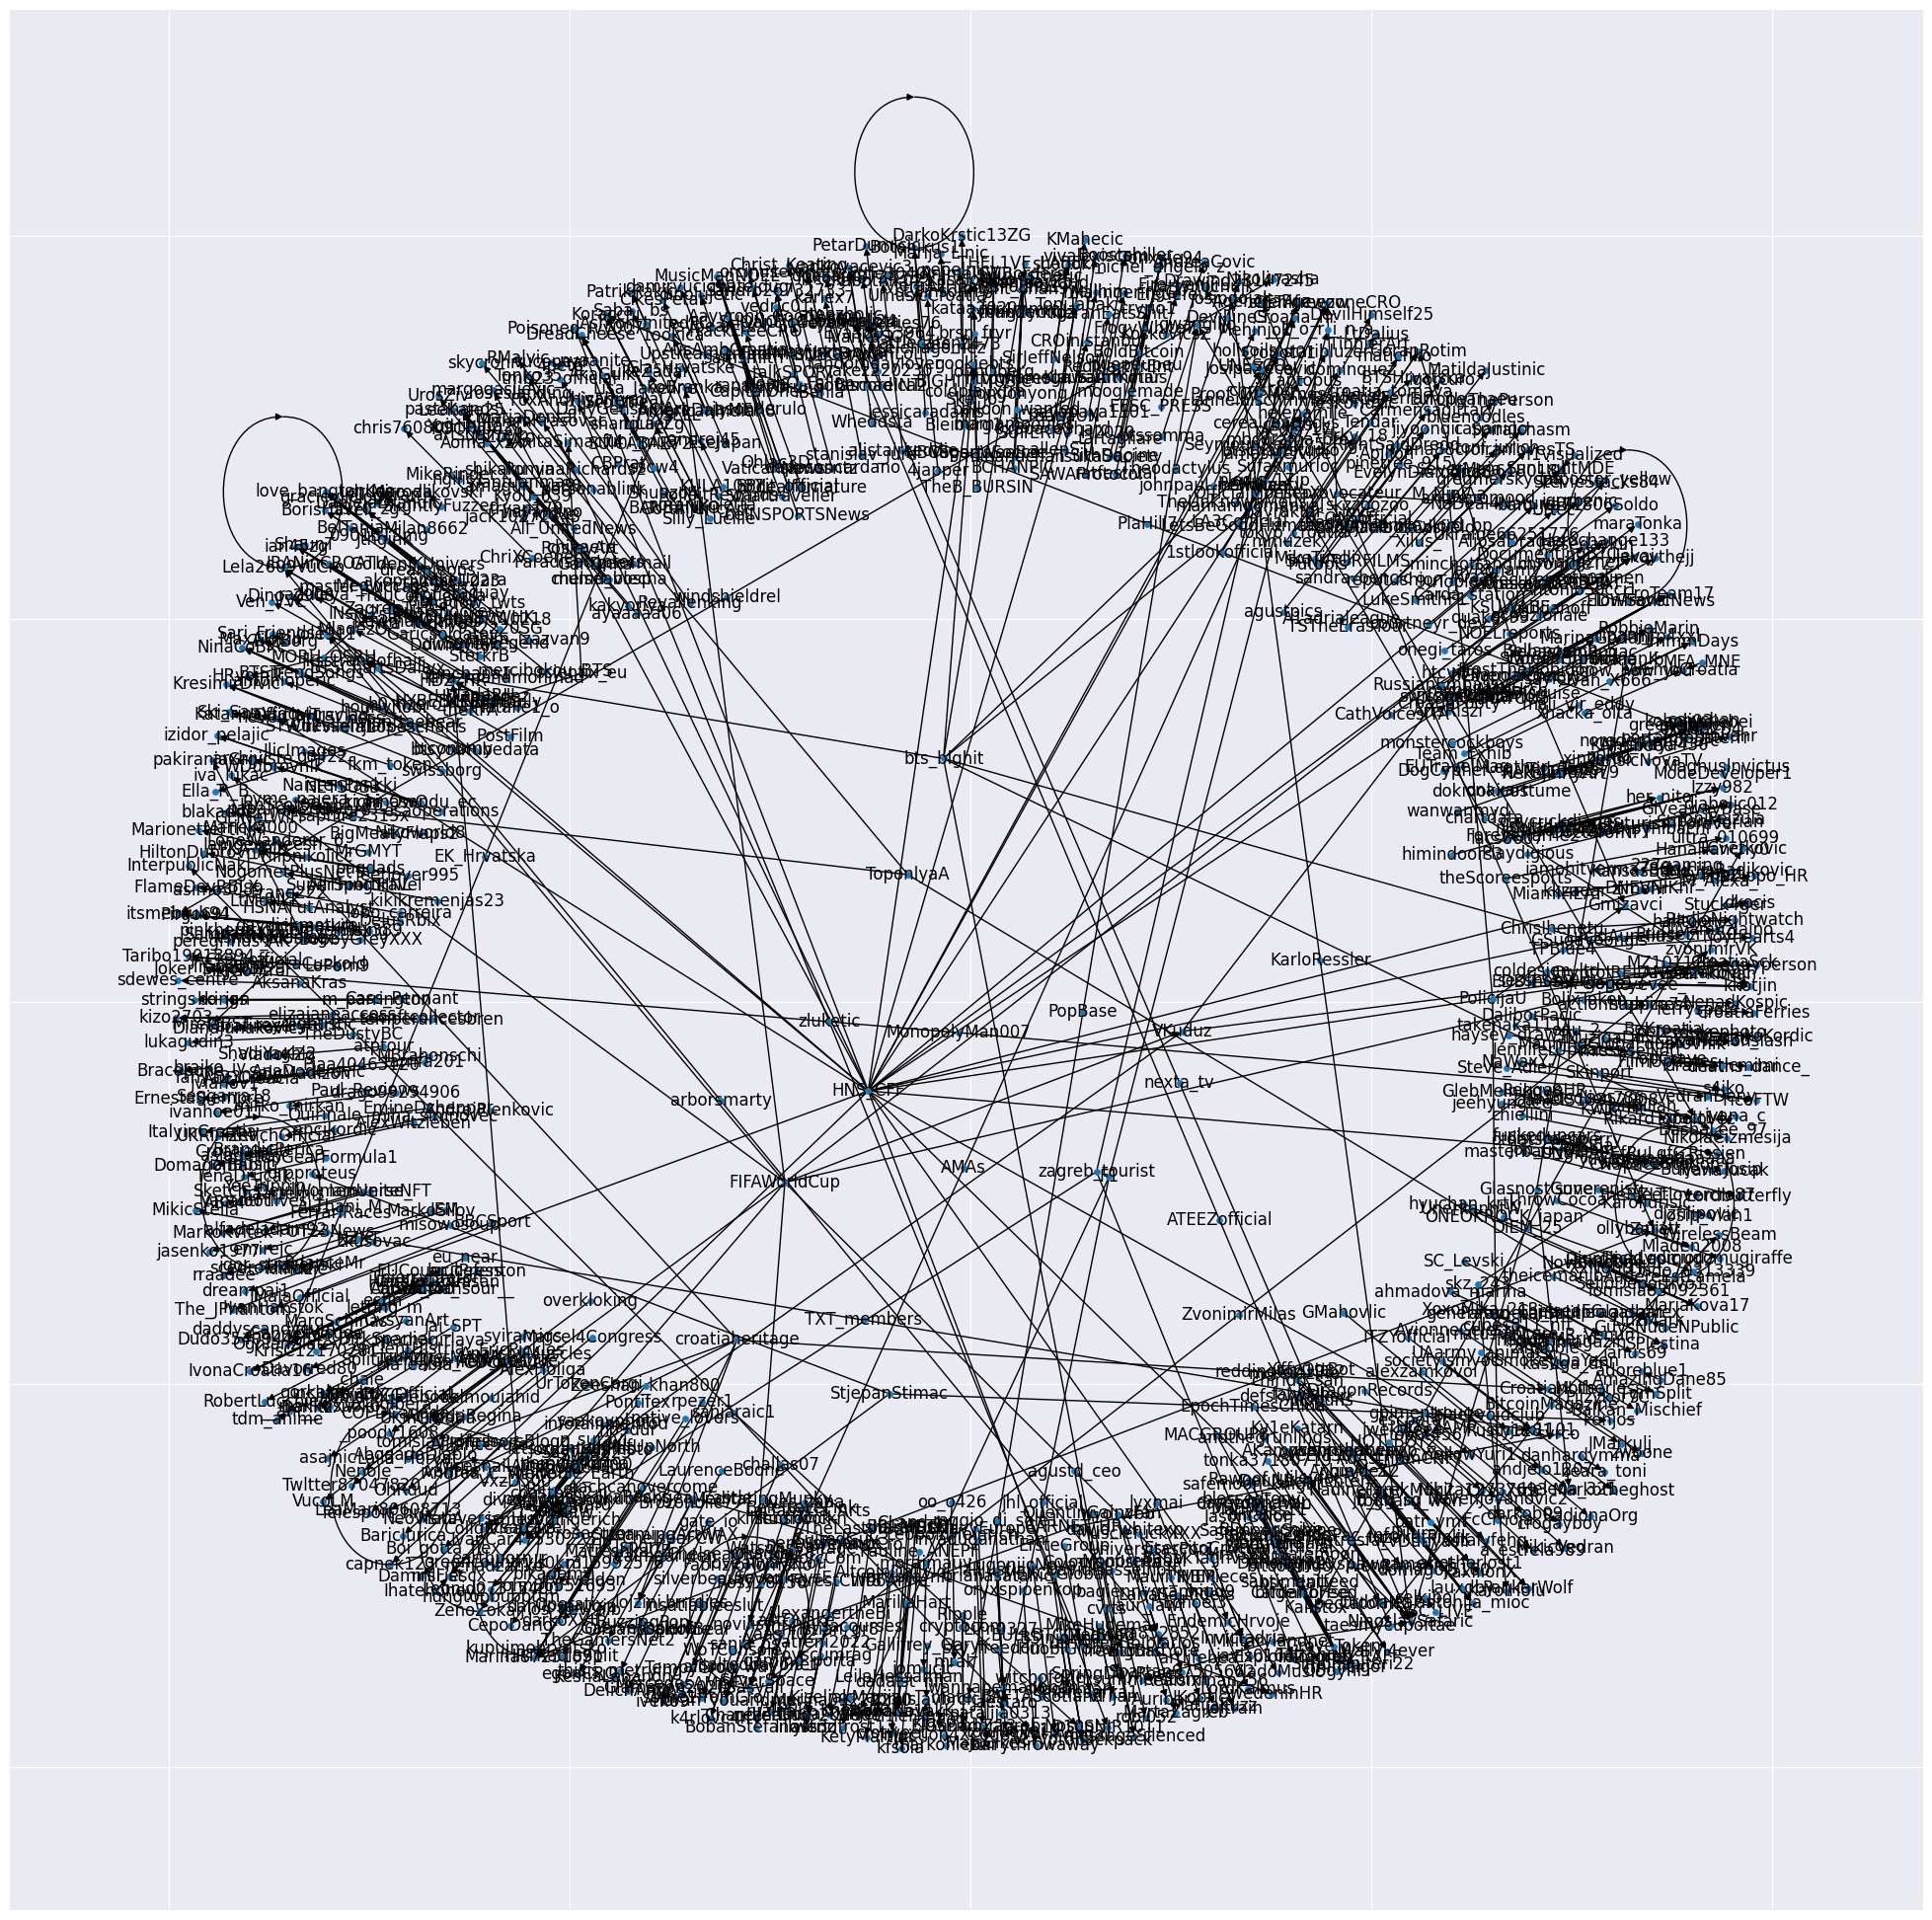

In [91]:
import networkx as nx

H = nx.from_pandas_edgelist(
    edgelist.sample(1000), 
    edge_attr=['weight', 'hashtag'], 
    create_using=nx.DiGraph
)

pos_spring = nx.spring_layout(H)
fig, ax = plt.subplots(1, figsize=(25, 25))
nx.draw_networkx(H, pos=pos_spring, node_size=15, ax=ax)

In [92]:
G = nx.from_pandas_edgelist(
    edgelist, 
    edge_attr=['weight', 'hashtag'], 
    create_using=nx.DiGraph,
)
pos_spring_all = nx.spring_layout(G)

In [93]:
degree_sequence = sorted((deg[1] for deg in G.degree()), reverse=True)

def get_average_degree(nx_graph):
    return sum(deg[1] for deg in nx_graph.degree()) / len(nx_graph.degree())


def get_clustering_coeff(nx_graph):
    largest_hubs, _ = get_largest_hubs(nx_graph)
    largest_hub = largest_hubs[0][0]
    return nx.clustering(nx_graph, largest_hub)


def get_largest_hubs(nx_graph, num=10):
    min_largest_degree = degree_sequence[num]
    return sorted(
        filter(lambda x: x[1] > min_largest_degree, nx_graph.degree()), 
        key=lambda x: x[1], 
        reverse=True
    )


def get_measures_df(nx_graph):
    data = [
        nx_graph.number_of_nodes(),
        nx_graph.number_of_edges(),
        round(get_average_degree(nx_graph), 2),
        round(nx.density(nx_graph), 2),
        #nx.number_connected_components(nx_graph)
    ]

    index = [
        'Broj čvorova (N)',
        'Broj veza (K)',
        'Prosječni stupanj ()',
        'Gustoća mreže (d)',
        # 'Broj komponenti'
    ]
    
    try:
        clustering_coeff = round(get_clustering_coeff(nx_graph), 2)
        assortativity_coeff = round(nx.degree_assortativity_coefficient(nx_graph), 2)
    except Exception:
        pass
    else:
        data.insert(-1, clustering_coeff)
        index.insert(-1, 'Koeficijent grupiranja (c)')
        data.insert(-1, assortativity_coeff)
        index.insert(-1, 'Koeficijent asortativnosti (a)')

    return pd.DataFrame(data=data, index=index, columns=['Iznos'])

get_measures_df(G)

Iznos
Broj čvorova (N)      10013.00
Broj veza (K)         10903.00
Prosječni stupanj ()      2.18
Gustoća mreže (d)         0.00

In [94]:
largest_hubs = get_largest_hubs(G, 10)
print("HUBs:", largest_hubs)
largest_hubs = [hub[0] for hub in largest_hubs]

HUBs: [('LeeKate25', 264), ('DreadCheese', 228), ('LTara5', 182), ('TrninicIgor', 154), ('HNS_CFF', 148), ('Yessenia_Zo', 132), ('Horan_youandme', 116), ('nenadzanko', 114), ('love_bangtanKoo', 105), ('FIFAWorldCup', 104)]


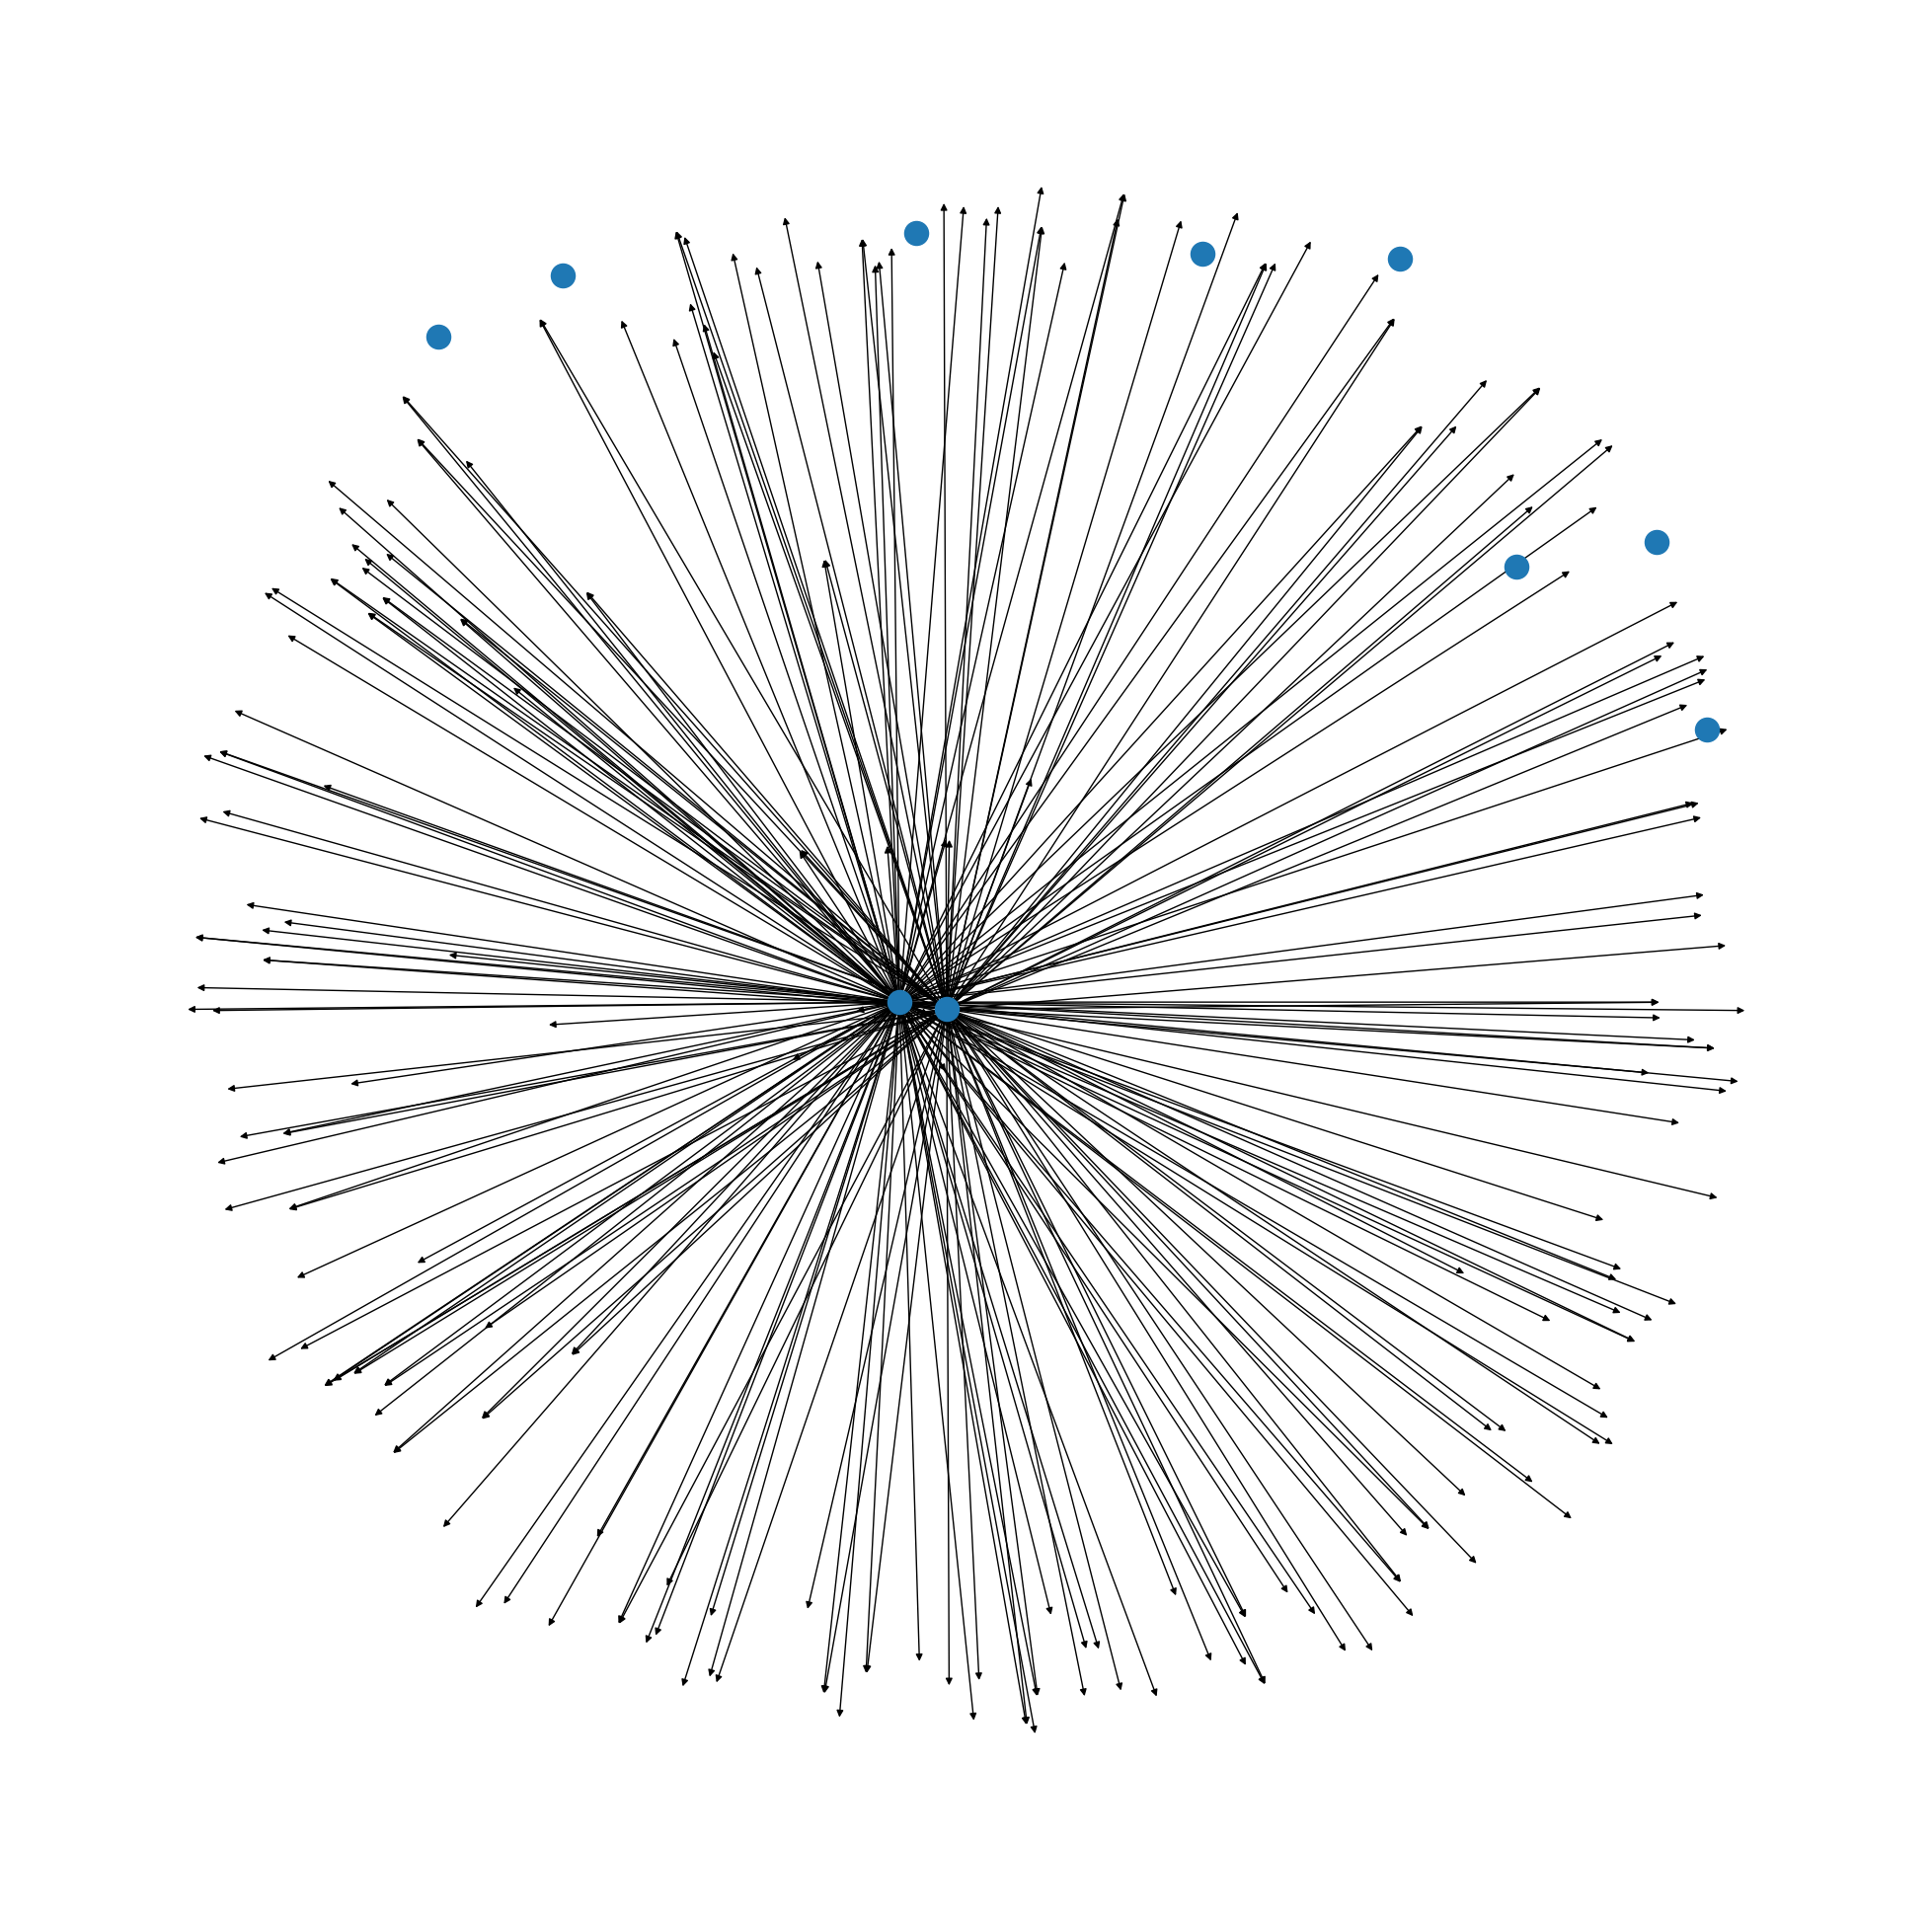

In [98]:
fig, ax = plt.subplots(1, figsize=(25, 25))
nx.draw(G, pos=pos_spring_all, nodelist=largest_hubs, edgelist=G.edges(largest_hubs), ax=ax)

In [109]:
from networkx.algorithms.community import girvan_newman
import itertools
import random

def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G, weight='weight')
    return max(centrality, key=centrality.get)

def get_communities(nx_graph, k=10):
    comp = girvan_newman(nx_graph, most_valuable_edge=most_central_edge)
    all_communities = []
    for communities in itertools.islice(comp, k):
        community = tuple(sorted(c) for c in communities)
        all_communities.append(community)
        print(community)
    
    # gn_communities = {
    #     node: i for i, nodes in enumerate(gn_communities) for node in nx_graph.nodes if i < 10
    # }
    # gn_community_colors = {
    #     community: '#' + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])
    #     for community in gn_communities.values()
    # }
    # gn_community_colors.update({-1: '#000000'})

    return all_communities

all_communities = get_communities(G)
print(all_communities)

(['007', '00Hpro', '00moonjuice', '01Btsxarmy', '01Btsxarmy1', '0325journals', '05tinghua23', '0901BTSmg', '0SHlKATSU', '0_Western_0', '0sei6', '0x1337_', '0x4682B4', '0xPolygon', '100Thieves', '100X_whale', '101greatgoals', '1075theriver', '10mulzomul', '11_chms', '12DAYSOFMOVIES', '1309zip', '131online', '13flr_escalator', '13red_rep', '1500tasvir_en', '16pxl', '17luj', '17saltywater', '1806Soldo', '1900800m', '1950balota', '1DTPWK18', '1DsWifei', '1_PARA_9', '1d__larry___', '1goonrich', '1nessuno100mil2', '1ookica', '1stlookofficial', '1wYkE201W5XZYcH', '20007Bita', '2000sPopTour', '2006_aicha', '2021JCrypto', '21aar_show', '21briwat', '227_staff', '227gaming', '24hoursoflemans', '24htaylor', '28HABITS_', '29lskz', '2BreakingNews4', '2XtzdSjBQh71aqr', '2_reiwa', '2bb_art', '2kouzabuta', '2ugMVCawDX2IUJU', '2yong2yong1', '308albi', '3244Furika', '32_yaa', '333shishishi333', '38NorthNK', '39_goodlove', '3Apocalisse', '44Observer4', '4Elenaaaa', '4everAnnina', '4frankbarat', '4japper',

In [106]:
nodes = G.nodes


AttributeError: 'dict' object has no attribute 'set_node_attr'